# Setup

In [1]:
import os

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imutils import paths
from skimage import io
from sklearn.model_selection import train_test_split

import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 

Segmentation Models: using `keras` framework.


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# set the random seed for random number generator to produce 
# similar results every time
np.random.seed(42)
tf.random.set_seed(42)

# Config

Download and copy the file contents from [Kaggle](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation) into the "dataset" folder in the root directory of this project.

In [4]:
# define the directory to your images
DATASET_DIR = r"dataset\lgg-mri-segmentation"
ORIGINAL_DATA_DIR = os.path.join(DATASET_DIR, "kaggle_3m")
print(f"Directory '{ORIGINAL_DATA_DIR}' exists: {os.path.exists(ORIGINAL_DATA_DIR)}")

# Setup training, validation and testing paths
# same with image collection notebook
TRAIN_PATH = os.path.join(DATASET_DIR, "training")
VAL_PATH = os.path.join(DATASET_DIR, "validation")
TEST_PATH = os.path.join(DATASET_DIR, "testing")

Directory 'dataset\lgg-mri-segmentation\kaggle_3m' exists: True


In [5]:
# Set up the splitting ratio for the 3 separate sets
TEST_SPLIT = 0.1
VAL_SPLIT = 0.1
TRAIN_SPLIT = 1.0 - TEST_SPLIT - VAL_SPLIT
TRAIN_SPLIT

0.8

In [6]:
# the image size that we want to resize into for training
IMG_HEIGHT = 256
IMG_WIDTH = 256
# 3 channels for our RGB images
IMG_CHANNELS = 3

## Training config

In [7]:
OUTPUTS_PATH = "outputs"
os.makedirs(OUTPUTS_PATH, exist_ok=True)

MODEL_PATH = os.path.join(OUTPUTS_PATH, "MRI_segmentation.h5")

In [8]:
LR = 1e-4
BATCH_SIZE = 8
EPOCHS = 10

# Prepare dataset

In [9]:
all_image_paths = list(paths.list_images(ORIGINAL_DATA_DIR))
len(all_image_paths)

7858

In [10]:
imagePaths = []
maskPaths = []
for img_path in all_image_paths:
    if "mask" in img_path:
        # mask images ends with "_mask.tif"
        maskPaths.append(img_path)
    else:
        imagePaths.append(img_path)

# sort them according to filenames to align with each other
maskPaths = sorted(maskPaths)
imagePaths = sorted(imagePaths)

print(len(imagePaths))
print(len(maskPaths))

3929
3929


## Split to train, validation, test datasets

In [11]:
print(TRAIN_PATH)
print(VAL_PATH)
print(TEST_PATH)

dataset\lgg-mri-segmentation\training
dataset\lgg-mri-segmentation\validation
dataset\lgg-mri-segmentation\testing


In [12]:
print(TRAIN_SPLIT)
print(VAL_SPLIT)
print(TEST_SPLIT)

0.8
0.1
0.1


In [13]:
# shuffle all the image and label paths together
random_idxs = np.arange(len(imagePaths))
np.random.shuffle(random_idxs)

imagePaths = np.array(imagePaths)[random_idxs]
maskPaths = np.array(maskPaths)[random_idxs]
print(len(imagePaths), len(maskPaths))

3929 3929


In [14]:
# split the dataset into rain:valid:test of ratio TRAIN_SPLIT:VAL_SPLIT:TEST_SPLIT
X_train, X_val_test, y_train, y_val_test = train_test_split(
    imagePaths, maskPaths, test_size=(VAL_SPLIT + TEST_SPLIT), random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test,
    y_val_test,
    test_size=(TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT)),
    random_state=42,
)

trainPct = len(X_train) / len(imagePaths) * 100
valPct = len(X_val) / len(imagePaths) * 100
testPct = len(X_test) / len(imagePaths) * 100

print(f"Total images = {len(imagePaths)}")
print(f"Total training images = {len(y_train)} ({trainPct:.1f} %)")
print(f"Total validation images = {len(y_val)} ({valPct:.1f} %)")
print(f"Total testing images = {len(y_test)} ({testPct:.1f} %)")

Total images = 3929
Total training images = 3143 (80.0 %)
Total validation images = 393 (10.0 %)
Total testing images = 393 (10.0 %)


# Inspecting dataset

In [111]:
# the mask image has a pixel value of 255 to indicate the presence of tumor
# there are also some images without any tumor, therefore I ran it through a loop to check
# for images with tumor
unique_pixel_set = set()
for mask_path in maskPaths:
    mask = io.imread(mask_path)
    unique_pixels = np.unique(mask)
    unique_pixel_set.update(unique_pixels)
unique_pixel_set

{0, 255}

In [116]:
mask = cv2.imread(maskPaths[3], cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
# minus 1 to reduce the minimum pixel value from 1 to 0
# for the model training to work properly
mask = mask.astype(np.int32)
print(np.unique(mask))

[  0 255]


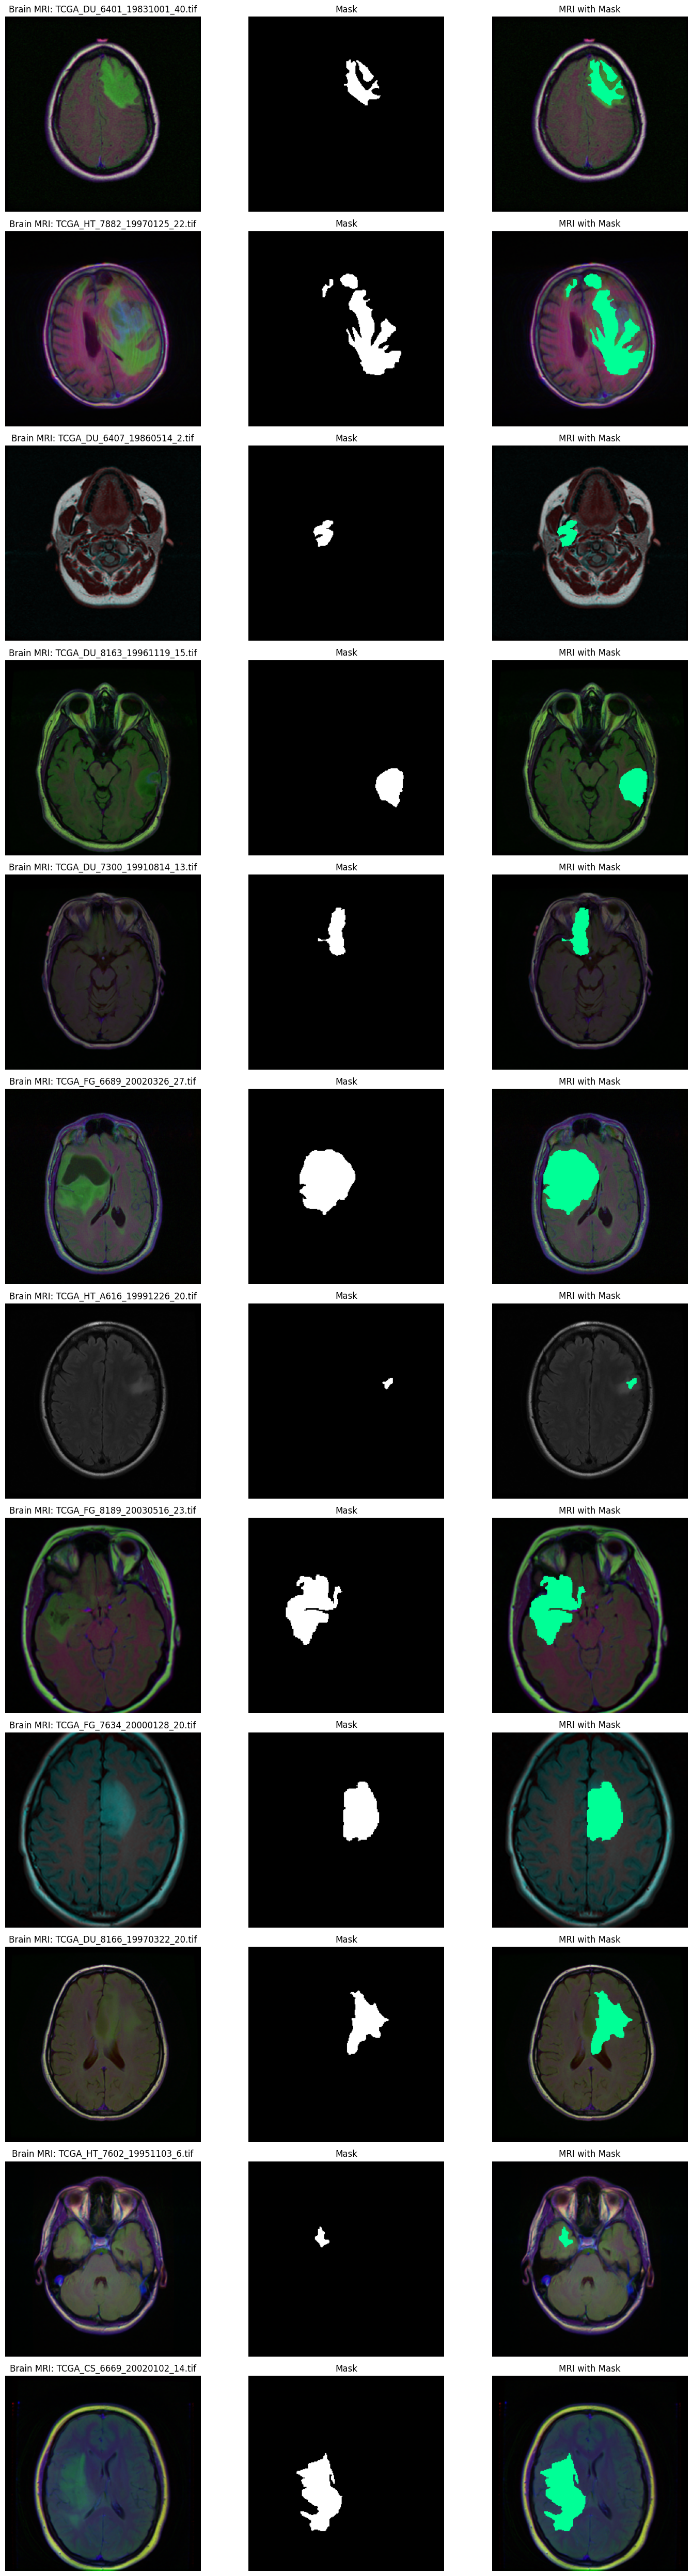

In [96]:
count = 1
ncols = 3
nrows = 12
total = ncols * nrows

plt.figure(figsize=(15,50))
for img_path, mask_path in zip(imagePaths, maskPaths):
    img = io.imread(img_path)
    filename = os.path.basename(img_path)
    mask = io.imread(mask_path)
    
    if len(np.unique(mask)) == 1:
        # skip if the entire mask image only contain black pixels (i.e. no mask)
        continue
    
    plt.subplot(nrows, ncols, count)
    plt.title(f"Brain MRI: {filename}")
    plt.axis('off')
    plt.imshow(img)

    plt.subplot(nrows, ncols, count + 1)
    plt.title("Mask")
    plt.axis('off')
    plt.imshow(mask, cmap='gray')

    plt.subplot(nrows, ncols, count + 2)
    img[mask==255] = (0,255,150)  # change pixel color at the position of mask
    plt.title("MRI with Mask")
    plt.axis('off')
    plt.imshow(img)
    
    # add the count of images shown
    count += 3
    if count >= total:
        break
    
plt.tight_layout()
plt.show()

# Preparing tf.data.Dataset

In [15]:
CLASSES = ['background', 'tumor']
N_CLASSES = 2

In [16]:
def read_image(imagePath):
    img = cv2.imread(imagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img.astype(np.float32) / 255.
    return img

def read_mask(maskPath):
    mask = cv2.imread(maskPath, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    # minus 1 to reduce the minimum pixel value from 1 to 0
    # for the model training to work properly
    mask = mask.astype(np.int32)
    return mask

In [17]:
def preprocess_data(imagePath, maskPath):
    def py_func(imagePath, maskPath):
        imagePath = imagePath.decode()
        maskPath = maskPath.decode()
        
        img = read_image(imagePath)
        mask = read_mask(maskPath)
        return img, mask
    
    # wrap the function and use it as a TF operation
    # to optimize for performance
    img, mask = tf.numpy_function(
        py_func,
        [imagePath, maskPath],
        [tf.float32, tf.int32]
    )
    
    # this is a very important step to one-hot encode the mask
    # based on the number of classes, and keep in mind that
    # this N_CLASSES will be the same as the number of filters of the 
    # final output Conv2D layer that we will build later
    mask = tf.one_hot(mask, depth=N_CLASSES, dtype=tf.int32)
    
    # set the shape to let TensorFlow knows about the shape
    # just like `assert`
    # NOTE: this step is required to show metrics during training
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, N_CLASSES])
    
    return img, mask

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)

Unique pixel values: [  0 255]


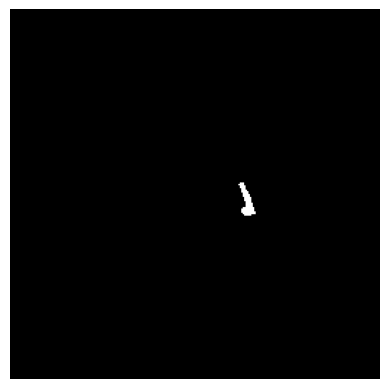

In [19]:
mask = read_mask(y_train[0])
print("Unique pixel values:", np.unique(mask))
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

In [20]:
for img, mask in train_ds.take(1):
    # the mask is one-hot encoded for each class, 2 in this case
    print(img.shape)
    print(mask.shape)

(256, 256, 3)
(256, 256, 2)


In [21]:
# converted to one-hot encoded labels across the "depth" axis,
# where this axis corresponds to the axis of the feature maps of 
# CNN layer
np.unique(mask.numpy())

array([0, 1])

# Optimize the tf.data.Dataset for performance

As explained in my previous notebooks for [image classification](https://github.com/ansonnn07/image-classification/blob/main/2.%20Training%20-%20Sign%20Language.ipynb).

In [23]:
train_ds = (train_ds
            .shuffle(len(X_train))
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
)

val_ds = (val_ds
          # no shuffle
          .cache()
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE)
)

test_ds = (test_ds
           # no shuffle
           .cache()
           .batch(BATCH_SIZE)
           .prefetch(AUTOTUNE)
)